# Introdução

Overview
The data has been split into two groups:

* training set (train.csv)
* test set (test.csv)


The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.


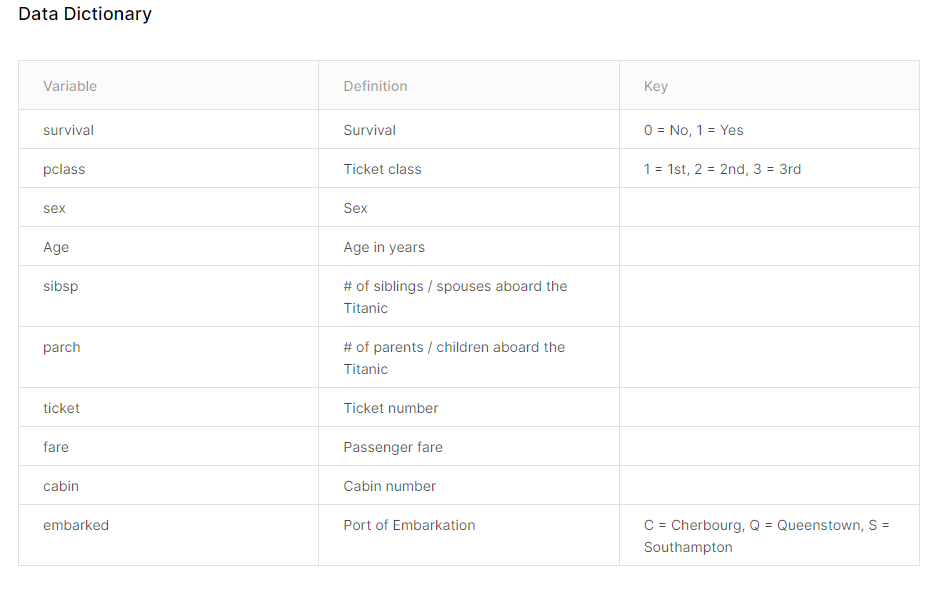

Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

# Pacotes e Intalação

In [42]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

#Model_Selection
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

# EDA

In [87]:
df = pd.read_csv("Dados/train.csv",index_col=0)

In [88]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [89]:
x = df.drop("Survived",axis=1).copy()
y = df.Survived

Vamos entender primeiro a distribuição entre nosso alvo "Survived"

In [25]:
y.value_counts(normalize=True).round(2)

0    0.62
1    0.38
Name: Survived, dtype: float64

Temos de inicial uma boa visão que 38% dos passageiros sobreviveram ao desastre. 

In [26]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Ticket       891 non-null    object 
 7   Fare         891 non-null    float64
dtypes: float64(1), int64(4), object(3)
memory usage: 55.8+ KB


In [27]:
x.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
SibSp          0
Parch          0
Ticket         0
Fare           0
dtype: int64

Vamos fazer nosso primeiro modelo "fraco", chamando de Baseline um modelo ignorando as colunas com dados faltantes.  E utilizando somente informações numéricas

In [121]:
def drop_columns_with_null_valuse(df):
    df.dropna(axis=1,inplace=True)
    try:
        df.drop("Fare",axis=1,inplace=True)
    except:
        pass
    return df

def drop_categorical_features(df):
    df = df.select_dtypes(exclude="object")
    return df
def saving_columns(df):
    global colunas 
    colunas= df.columns
    return df

get_drop_columns_with_null_valuse = FunctionTransformer(drop_columns_with_null_valuse,validate=False)
get_drop_categorical_features = FunctionTransformer(drop_categorical_features,validate=False)
get_colums_names = FunctionTransformer(saving_columns,validate=False)

# Models

In [90]:
x_train, x_val, y_train, y_val = train_test_split(x,y,
                                                    test_size = 0.3,
                                                    random_state = 0)

In [122]:
pipe1 = Pipeline(memory=None,
                 steps = [
                     ("Feature_Selection",get_drop_categorical_features),
                     ("Null_Validate",get_drop_columns_with_null_valuse),
                     ("Final_Columns",get_colums_names),
                     ("RandomForest", RandomForestClassifier() )
                 ],
                verbose=False
                )

In [123]:
pipe1.fit(x_train,y_train)
print("Score: ", pipe1.score(x_val,y_val))

Score:  0.7238805970149254


In [124]:
x_test = pd.read_csv("Dados/test.csv",index_col = 0)

In [125]:
predict_array = pipe1.predict(x_test)

In [128]:
predict_submission = pd.DataFrame({"PassengerId":x_test.index,"Survived":predict_array})

In [129]:
predict_submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [130]:
predict_submission.to_csv("Predições/Predict1.csv",index=False)

In [131]:
pipe1.named_steps['RandomForest'].feature_importances_

array([0.48569558, 0.27810361, 0.23620081])

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt
importances = pipe1.named_steps['RandomForest'].feature_importances_

feature_df = pd.DataFrame(list(zip(colunas, importances)), columns = ["feature","importance"])
feature_df = feature_df.sort_values(by='importance', ascending=False,)


# image formatting
axis_fs = 18 #fontsize
title_fs = 22 #fontsize
sns.set(style="whitegrid")

ax = sns.barplot(x="importance", y="feature", data=feature_df)
ax.set_xlabel('Importance',fontsize = axis_fs)
ax.set_ylabel('Feature', fontsize = axis_fs)#ylabel
ax.set_title('Random forest\nfeature importance', fontsize = title_fs)

plt.tight_layout()
plt.savefig("feature_importance.png",dpi=120)
plt.close()


In [119]:
pipe1.named_steps['Null_Validate'].columns

AttributeError: 'FunctionTransformer' object has no attribute 'columns'

In [134]:
colunas

Index(['Pclass', 'SibSp', 'Parch'], dtype='object')

In [193]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

#Model_Selection
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")


import matplotlib.pyplot as plt
import seaborn as sns

from Pipeline import get_drop_categorical_features,get_drop_columns_with_null_valuse,get_colums_names



df = pd.read_csv("Dados/train.csv",index_col=0)
x = df.drop("Survived",axis=1).copy()
y = df.Survived



x_train, x_val, y_train, y_val = train_test_split(x,y,
                                                    test_size = 0.3,
                                                    random_state = 0)


pipe1 = Pipeline(memory=None,
                 steps = [
                     ("Feature_Selection",get_drop_categorical_features),
                     ("Null_Validate",get_drop_columns_with_null_valuse),
                     ("Final_Columns",get_colums_names),
                     ("RandomForest", RandomForestClassifier() )
                 ],
                verbose=False
                )

pipe2 = Pipeline(memory=None,
                 steps = [
                     ("Feature_Selection",get_drop_categorical_features),
                     ("Null_Validate",get_drop_columns_with_null_valuse),
                     ("Final_Columns",get_colums_names),
                     ("LogisticRegression", LogisticRegression() )
                 ],
                verbose=False
                )

#Salvando Scores
modelos_testados = {"Modelos":["RandomForestClassifier","LogisticRegression"],
                    "Pipeline":[pipe1,pipe2],
                    "Score":[],
                    "Steps":[]
                    }
n = len(modelos_testados["Modelos"])
with open("metrics.txt", 'w') as outfile:
    for ref in range(n):
        modelos_testados["Pipeline"][ref].fit(x_train,y_train)
        test_score = modelos_testados["Pipeline"][ref].score(x_val,y_val)
        nome_modelo = modelos_testados["Modelos"][ref]
        steps = modelos_testados["Pipeline"][ref].named_steps.keys()
        outfile.write(f"{nome_modelo}- Test Score: {test_score} - Steps: {steps}")
        modelos_testados["Score"].append(test_score)
        modelos_testados["Steps"].append(steps)


df_modelos = pd.DataFrame({"Model":modelos_testados["Modelos"], "Score":modelos_testados["Score"], "Steps":modelos_testados["Steps"]})
df_modelos.head()


#Aqui precisamos escolher o melhor Modelo para usar como Pipe e fazer o predict

,Model,Score,Steps
0,RandomForestClassifier,0.727612,"(Feature_Selection, Null_Validate, Final_Colum..."
1,LogisticRegression,0.701493,"(Feature_Selection, Null_Validate, Final_Colum..."


teste /n

In [212]:
df_modelos = pd.DataFrame({"Model":modelos_testados["Modelos"], "Score":modelos_testados["Score"], "Steps":modelos_testados["Steps"]})
df_modelos.to_markdown("Modeleos.md",index=False)

In [150]:
lista_score = []
for modelo in modelos_testados.keys():
    lista_score.append(modelos_testados[modelo]["Score"])
    

In [155]:
max(lista_score)

0.7313432835820896

In [ ]:
lista_score = [score for modelo in modelos_testados.keys()]

In [163]:
d = {'Model1':{"Score":15},'b':{"Score":10},'c':{"Score":5}}
d.get(max(d, key=lambda x: x[0]['Score']))

TypeError: string indices must be integers

In [158]:
modelos_testados

{'RandomForestClassifier': {'Pipeline': Pipeline(steps=[('Feature_Selection',
                   FunctionTransformer(func=<function drop_categorical_features at 0x0000023283EB7670>)),
                  ('Null_Validate',
                   FunctionTransformer(func=<function drop_columns_with_null_valuse at 0x0000023283F22550>)),
                  ('Final_Columns',
                   FunctionTransformer(func=<function saving_columns at 0x0000023281E66C10>)),
                  ('RandomForest', RandomForestClassifier())]),
  'Score': 0.7313432835820896},
 'LogisticRegression': {'Pipeline': Pipeline(steps=[('Feature_Selection',
                   FunctionTransformer(func=<function drop_categorical_features at 0x0000023283EB7670>)),
                  ('Null_Validate',
                   FunctionTransformer(func=<function drop_columns_with_null_valuse at 0x0000023283F22550>)),
                  ('Final_Columns',
                   FunctionTransformer(func=<function saving_columns at 0x0000023

In [160]:
modelos_testados.sort(key=lambda x: x[0]['Score'], reverse=False)

AttributeError: 'dict' object has no attribute 'sort'

In [161]:
modelos_testados

{'RandomForestClassifier': {'Pipeline': Pipeline(steps=[('Feature_Selection',
                   FunctionTransformer(func=<function drop_categorical_features at 0x0000023283EB7670>)),
                  ('Null_Validate',
                   FunctionTransformer(func=<function drop_columns_with_null_valuse at 0x0000023283F22550>)),
                  ('Final_Columns',
                   FunctionTransformer(func=<function saving_columns at 0x0000023281E66C10>)),
                  ('RandomForest', RandomForestClassifier())]),
  'Score': 0.7313432835820896},
 'LogisticRegression': {'Pipeline': Pipeline(steps=[('Feature_Selection',
                   FunctionTransformer(func=<function drop_categorical_features at 0x0000023283EB7670>)),
                  ('Null_Validate',
                   FunctionTransformer(func=<function drop_columns_with_null_valuse at 0x0000023283F22550>)),
                  ('Final_Columns',
                   FunctionTransformer(func=<function saving_columns at 0x0000023